# Análise ENA - Energia Natural Afluente das Bacias Hidrográficas Brasileiras

Este notebook apresenta uma análise das bacias hidrográficas brasileiras e foco na bacia do TOCANTINS

## 1. Importação e Configuração

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (15, 8),
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'font.size': 11,
    'grid.alpha': 0.3
})

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## 2. Carregamento e Limpeza dos Dados

In [2]:
# Carregar dados
df = pd.read_csv('../data/ENA_DIARIO_BACIAS_CONSOLIDADO_2000-2025.csv', sep=';', decimal='.')
print(f"Dataset carregado: {df.shape}")

# Preparar dados
df['data'] = pd.to_datetime(df['ena_data'])
df = df.set_index('data')
print(f"Período: {df.index.min()} até {df.index.max()}")

# Renomear colunas para facilitar
df.rename(columns={'nom_bacia': 'bacia', 'ena_bruta_bacia_mwmed': 'ena'}, inplace=True)

# Remover valores zero (dados inconsistentes)
df_original = df.copy()
df = df[df['ena'] > 0]
print(f"Registros removidos (zeros): {len(df_original) - len(df)}")
print(f"Dados finais: {df.shape}")

Dataset carregado: (208807, 6)
Período: 2000-01-01 00:00:00 até 2025-09-21 00:00:00
Registros removidos (zeros): 14888
Dados finais: (193919, 6)


## 3. Análise Geral das Bacias

=== RANKING DAS BACIAS POR ENA MÉDIA ===
               count      mean     cv
bacia                                
PARANA          9396  15722.80  0.481
TOCANTINS       9396   7444.08  0.891
SAO FRANCISCO   9396   5451.41  0.870
AMAZONAS        9396   4495.38  1.694
IGUACU          9396   4483.24  0.861
PARANAIBA       9396   4161.30  0.721
GRANDE          9396   4110.14  0.765
URUGUAI         9396   3242.32  1.322
PARANAPANEMA    9396   1670.07  0.711
TIETE           9396   1202.78  0.736


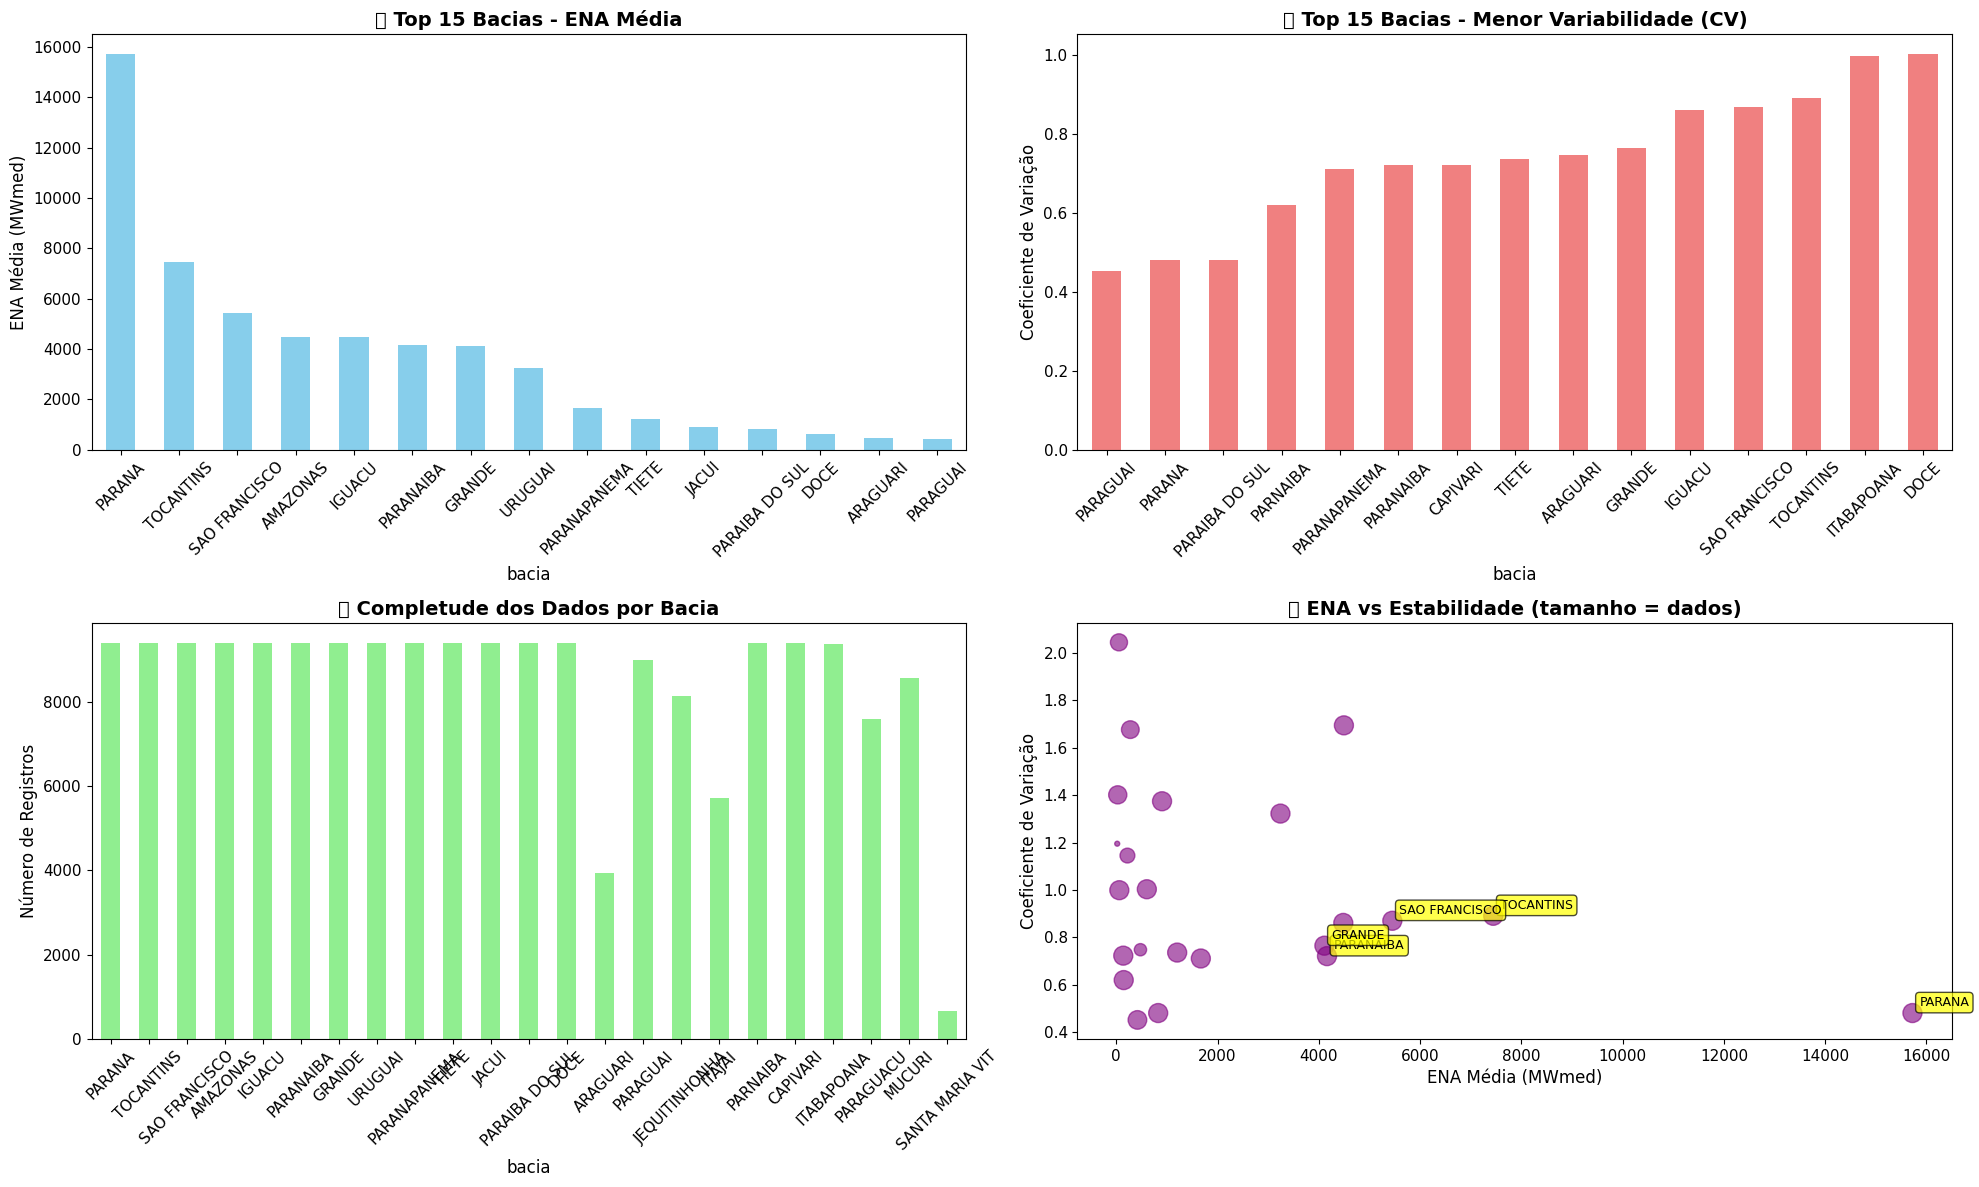

In [3]:
# Estatísticas gerais por bacia
stats_bacias = df.groupby('bacia')['ena'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(2)
stats_bacias['cv'] = (stats_bacias['std'] / stats_bacias['mean']).round(3)
stats_bacias = stats_bacias.sort_values('mean', ascending=False)

print("=== RANKING DAS BACIAS POR ENA MÉDIA ===")
print(stats_bacias[['count', 'mean', 'cv']].head(10))

# Visualização das bacias
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. ENA média por bacia
top_bacias = stats_bacias.head(15)
top_bacias['mean'].plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('🏆 Top 15 Bacias - ENA Média', fontweight='bold')
axes[0,0].set_ylabel('ENA Média (MWmed)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Coeficiente de Variação
cv_sorted = stats_bacias.sort_values('cv')
cv_sorted['cv'].head(15).plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('📊 Top 15 Bacias - Menor Variabilidade (CV)', fontweight='bold')
axes[0,1].set_ylabel('Coeficiente de Variação')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Completude dos dados
stats_bacias['count'].plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('📈 Completude dos Dados por Bacia', fontweight='bold')
axes[1,0].set_ylabel('Número de Registros')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Scatter: ENA vs Estabilidade
scatter = axes[1,1].scatter(stats_bacias['mean'], stats_bacias['cv'], 
                           s=stats_bacias['count']/50, alpha=0.6, c='purple')
axes[1,1].set_xlabel('ENA Média (MWmed)')
axes[1,1].set_ylabel('Coeficiente de Variação')
axes[1,1].set_title('🎯 ENA vs Estabilidade (tamanho = dados)', fontweight='bold')

# Destacar algumas bacias importantes
bacias_destaque = ['TOCANTINS', 'PARANAIBA', 'GRANDE', 'PARANA', 'SAO FRANCISCO']
for bacia in bacias_destaque:
    if bacia in stats_bacias.index:
        x = stats_bacias.loc[bacia, 'mean']
        y = stats_bacias.loc[bacia, 'cv']
        axes[1,1].annotate(bacia, (x, y), xytext=(5, 5), 
                          textcoords='offset points', fontsize=9, 
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

## 4. Por que escolhemos TOCANTINS?

**Critérios de Seleção:**
1. **Alto volume de ENA**: Entre as maiores do Brasil
2. **Boa estabilidade**: Coeficiente de variação moderado
3. **Dados completos**: Alta completude temporal
4. **Relevância energética**: Importante para o SIN
5. **Padrões sazonais claros**: Ideal para modelagem

In [4]:
# Justificativa da escolha do TOCANTINS
print("=== POR QUE TOCANTINS? ===")
print("🎯 CRITÉRIOS DE SELEÇÃO ATENDIDOS:")

if 'TOCANTINS' in stats_bacias.index:
    tocantins_stats = stats_bacias.loc['TOCANTINS']
    ranking_ena = (stats_bacias['mean'] >= tocantins_stats['mean']).sum()
    ranking_cv = (stats_bacias['cv'] <= tocantins_stats['cv']).sum()
    ranking_dados = (stats_bacias['count'] >= tocantins_stats['count']).sum()
    
    print(f"✅ ENA Média: {tocantins_stats['mean']:.1f} MWmed (#{ranking_ena} no ranking)")
    print(f"✅ Estabilidade: CV = {tocantins_stats['cv']:.3f} (#{ranking_cv} mais estável)")
    print(f"✅ Completude: {tocantins_stats['count']:,} registros (#{ranking_dados} em dados)")
    print(f"✅ Período: {tocantins_stats['count']/365.25:.1f} anos de dados")
    
    # Comparar com outras bacias importantes
    print("\n📊 COMPARAÇÃO COM OUTRAS BACIAS IMPORTANTES:")
    bacias_comparacao = ['PARANAIBA', 'GRANDE', 'SAO FRANCISCO', 'PARANA']
    for bacia in bacias_comparacao:
        if bacia in stats_bacias.index:
            comp_stats = stats_bacias.loc[bacia]
            print(f"{bacia:12s}: ENA={comp_stats['mean']:6.1f}, CV={comp_stats['cv']:.3f}, Dados={comp_stats['count']:,}")
    
    print(f"{'TOCANTINS':12s}: ENA={tocantins_stats['mean']:6.1f}, CV={tocantins_stats['cv']:.3f}, Dados={tocantins_stats['count']:,} ⭐")
    
else:
    print("❌ TOCANTINS não encontrado nos dados")
    print("Bacias disponíveis:", list(stats_bacias.index))

print("\n🏆 TOCANTINS escolhido por combinar alto volume, estabilidade e completude!")

=== POR QUE TOCANTINS? ===
🎯 CRITÉRIOS DE SELEÇÃO ATENDIDOS:
✅ ENA Média: 7444.1 MWmed (#2 no ranking)
✅ Estabilidade: CV = 0.891 (#13 mais estável)
✅ Completude: 9,396.0 registros (#15 em dados)
✅ Período: 25.7 anos de dados

📊 COMPARAÇÃO COM OUTRAS BACIAS IMPORTANTES:
PARANAIBA   : ENA=4161.3, CV=0.721, Dados=9,396.0
GRANDE      : ENA=4110.1, CV=0.765, Dados=9,396.0
SAO FRANCISCO: ENA=5451.4, CV=0.870, Dados=9,396.0
PARANA      : ENA=15722.8, CV=0.481, Dados=9,396.0
TOCANTINS   : ENA=7444.1, CV=0.891, Dados=9,396.0 ⭐

🏆 TOCANTINS escolhido por combinar alto volume, estabilidade e completude!


## 5. Análise Detalhada - Bacia TOCANTINS

=== DADOS TOCANTINS ===
Registros: 9,396
Período: 2000-01-01 00:00:00 até 2025-09-21 00:00:00
Média: 7444.08 MWmed
Desvio: 6629.23 MWmed


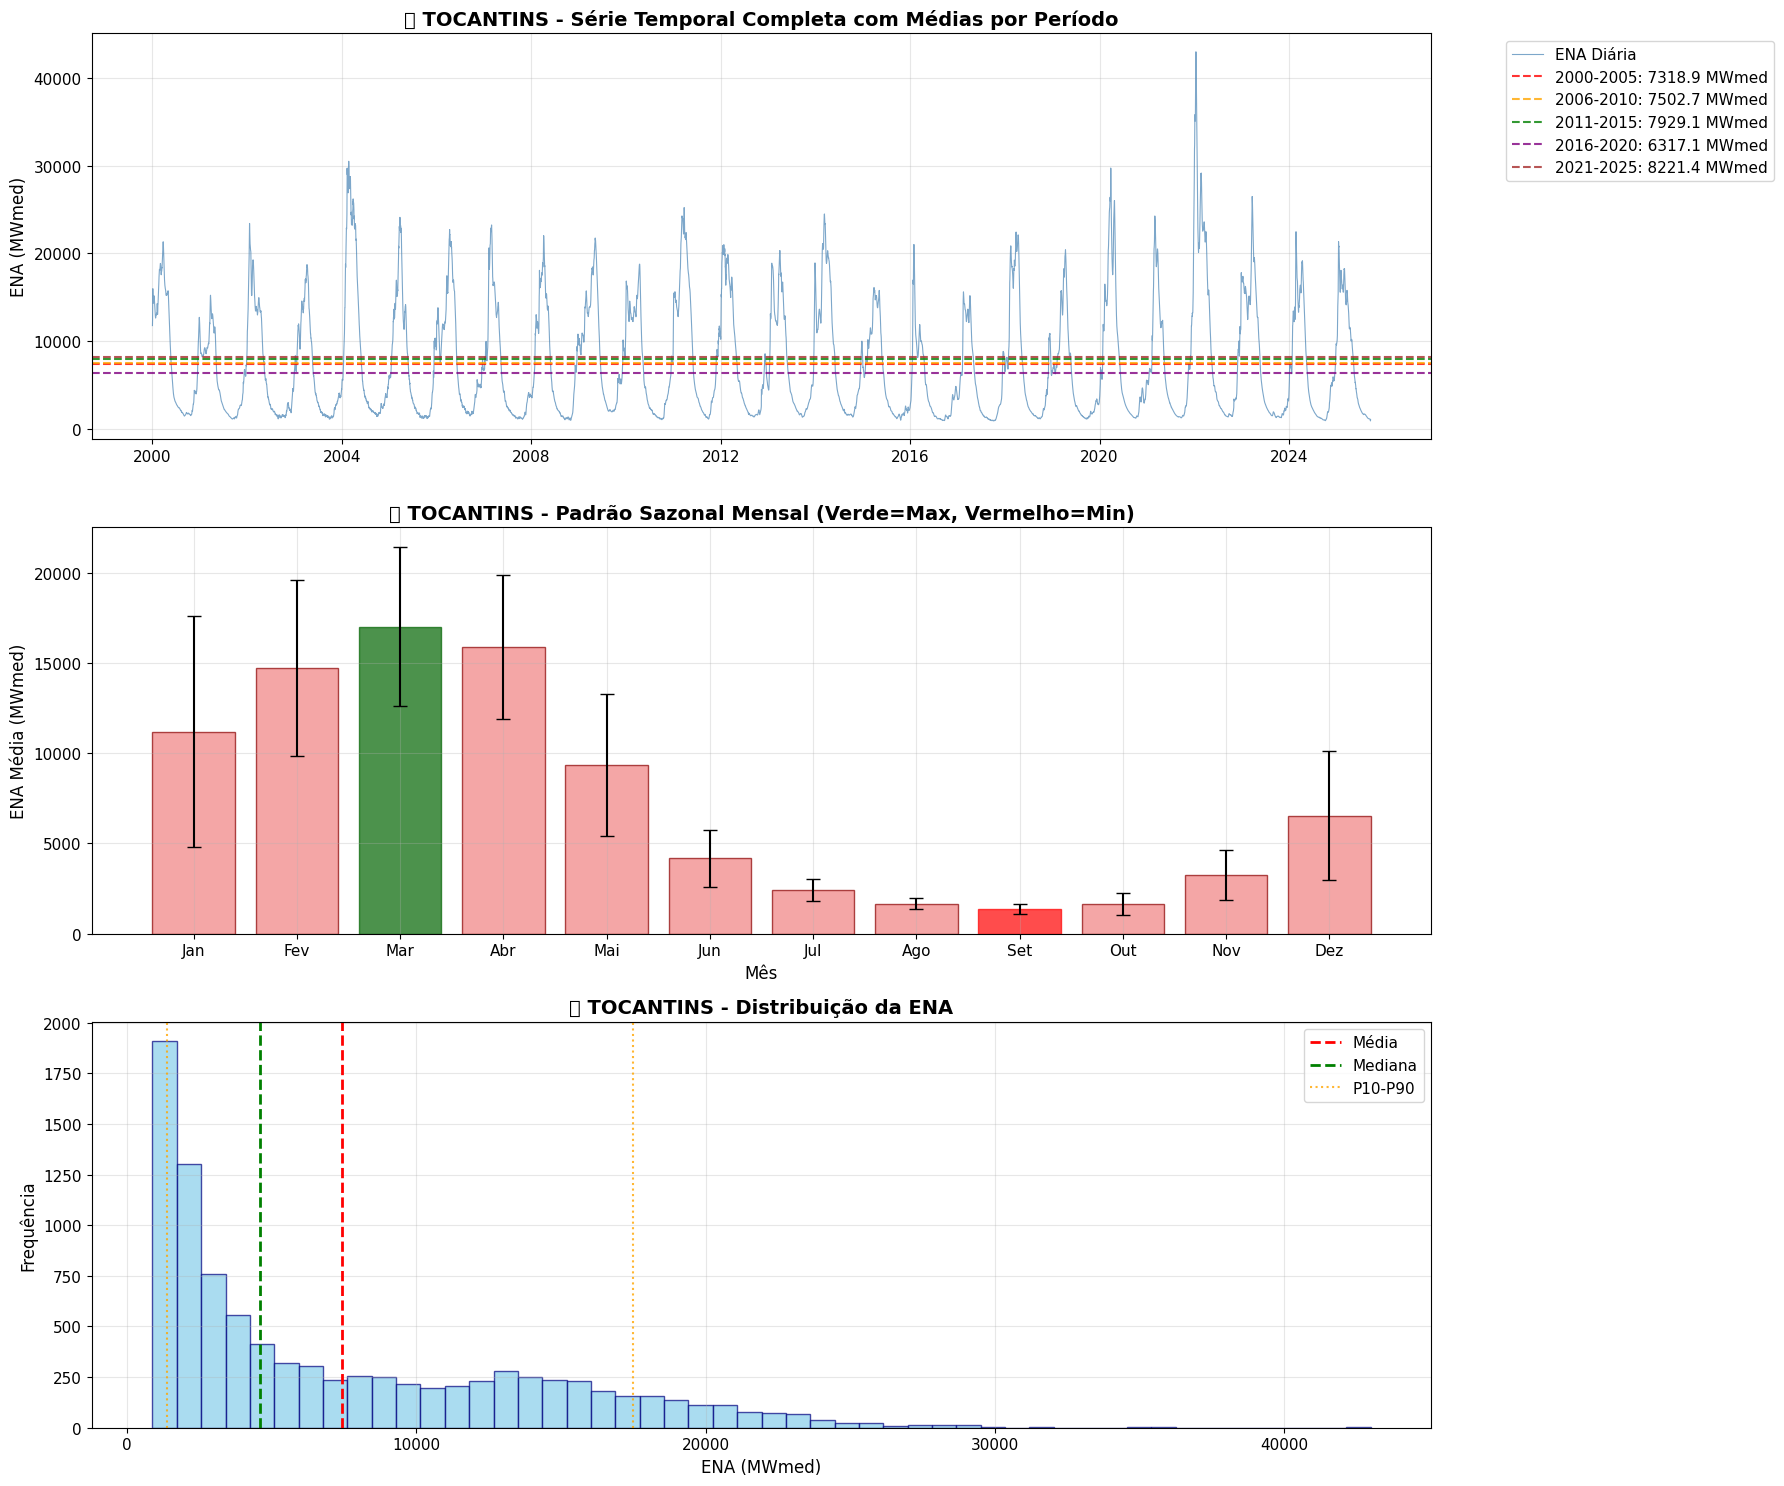


🌊 PADRÕES SAZONAIS:
Mês com maior ENA: Mar (17042.8 MWmed)
Mês com menor ENA: Set (1364.5 MWmed)
Amplitude sazonal: 15678.4 MWmed


In [5]:
# Extrair dados do TOCANTINS
tocantins = df[df['bacia'] == 'TOCANTINS'].copy()
serie_tocantins = tocantins['ena']

print(f"=== DADOS TOCANTINS ===")
print(f"Registros: {len(serie_tocantins):,}")
print(f"Período: {serie_tocantins.index[0]} até {serie_tocantins.index[-1]}")
print(f"Média: {serie_tocantins.mean():.2f} MWmed")
print(f"Desvio: {serie_tocantins.std():.2f} MWmed")

# Visualização da série temporal com tags diferentes
fig, axes = plt.subplots(3, 1, figsize=(18, 15))

# 1. Série completa com diferentes períodos destacados
axes[0].plot(serie_tocantins.index, serie_tocantins.values, 
            linewidth=0.8, alpha=0.7, color='steelblue', label='ENA Diária')

# Destacar diferentes períodos com cores
periodos = {
    '2000-2005': 'red',
    '2006-2010': 'orange', 
    '2011-2015': 'green',
    '2016-2020': 'purple',
    '2021-2025': 'brown'
}

for periodo, cor in periodos.items():
    inicio, fim = periodo.split('-')
    mask = (serie_tocantins.index.year >= int(inicio)) & (serie_tocantins.index.year <= int(fim))
    if mask.any():
        dados_periodo = serie_tocantins[mask]
        media_periodo = dados_periodo.mean()
        axes[0].axhline(y=media_periodo, color=cor, linestyle='--', alpha=0.8, 
                       label=f'{periodo}: {media_periodo:.1f} MWmed')

axes[0].set_title('📊 TOCANTINS - Série Temporal Completa com Médias por Período', fontweight='bold', fontsize=14)
axes[0].set_ylabel('ENA (MWmed)')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. Sazonalidade mensal
monthly_data = serie_tocantins.groupby(serie_tocantins.index.month).agg(['mean', 'std'])
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

bars = axes[1].bar(range(1, 13), monthly_data['mean'], yerr=monthly_data['std'], 
                   capsize=5, alpha=0.7, color='lightcoral', edgecolor='darkred')

# Colorir meses de alta e baixa ENA
max_mes = monthly_data['mean'].idxmax()
min_mes = monthly_data['mean'].idxmin()
bars[max_mes-1].set_color('darkgreen')  # Mês de maior ENA
bars[min_mes-1].set_color('red')        # Mês de menor ENA

axes[1].set_title('🌊 TOCANTINS - Padrão Sazonal Mensal (Verde=Max, Vermelho=Min)', fontweight='bold')
axes[1].set_xlabel('Mês')
axes[1].set_ylabel('ENA Média (MWmed)')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(meses)
axes[1].grid(True, alpha=0.3)

# 3. Distribuição e outliers
axes[2].hist(serie_tocantins, bins=50, alpha=0.7, color='skyblue', edgecolor='navy')
axes[2].axvline(serie_tocantins.mean(), color='red', linestyle='--', linewidth=2, label='Média')
axes[2].axvline(serie_tocantins.median(), color='green', linestyle='--', linewidth=2, label='Mediana')

# Marcar percentis
p10 = serie_tocantins.quantile(0.1)
p90 = serie_tocantins.quantile(0.9)
axes[2].axvline(p10, color='orange', linestyle=':', alpha=0.8, label='P10-P90')
axes[2].axvline(p90, color='orange', linestyle=':', alpha=0.8)

axes[2].set_title('📈 TOCANTINS - Distribuição da ENA', fontweight='bold')
axes[2].set_xlabel('ENA (MWmed)')
axes[2].set_ylabel('Frequência')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas sazonais
print(f"\n🌊 PADRÕES SAZONAIS:")
print(f"Mês com maior ENA: {meses[max_mes-1]} ({monthly_data.loc[max_mes, 'mean']:.1f} MWmed)")
print(f"Mês com menor ENA: {meses[min_mes-1]} ({monthly_data.loc[min_mes, 'mean']:.1f} MWmed)")
print(f"Amplitude sazonal: {monthly_data['mean'].max() - monthly_data['mean'].min():.1f} MWmed")

## 6. Análise Estatística com Statsmodels

=== TESTE DE ESTACIONARIDADE (ADF) ===
Estatística ADF: -8.720789
p-value: 0.000000
✅ Série é ESTACIONÁRIA

=== DECOMPOSIÇÃO SAZONAL ===


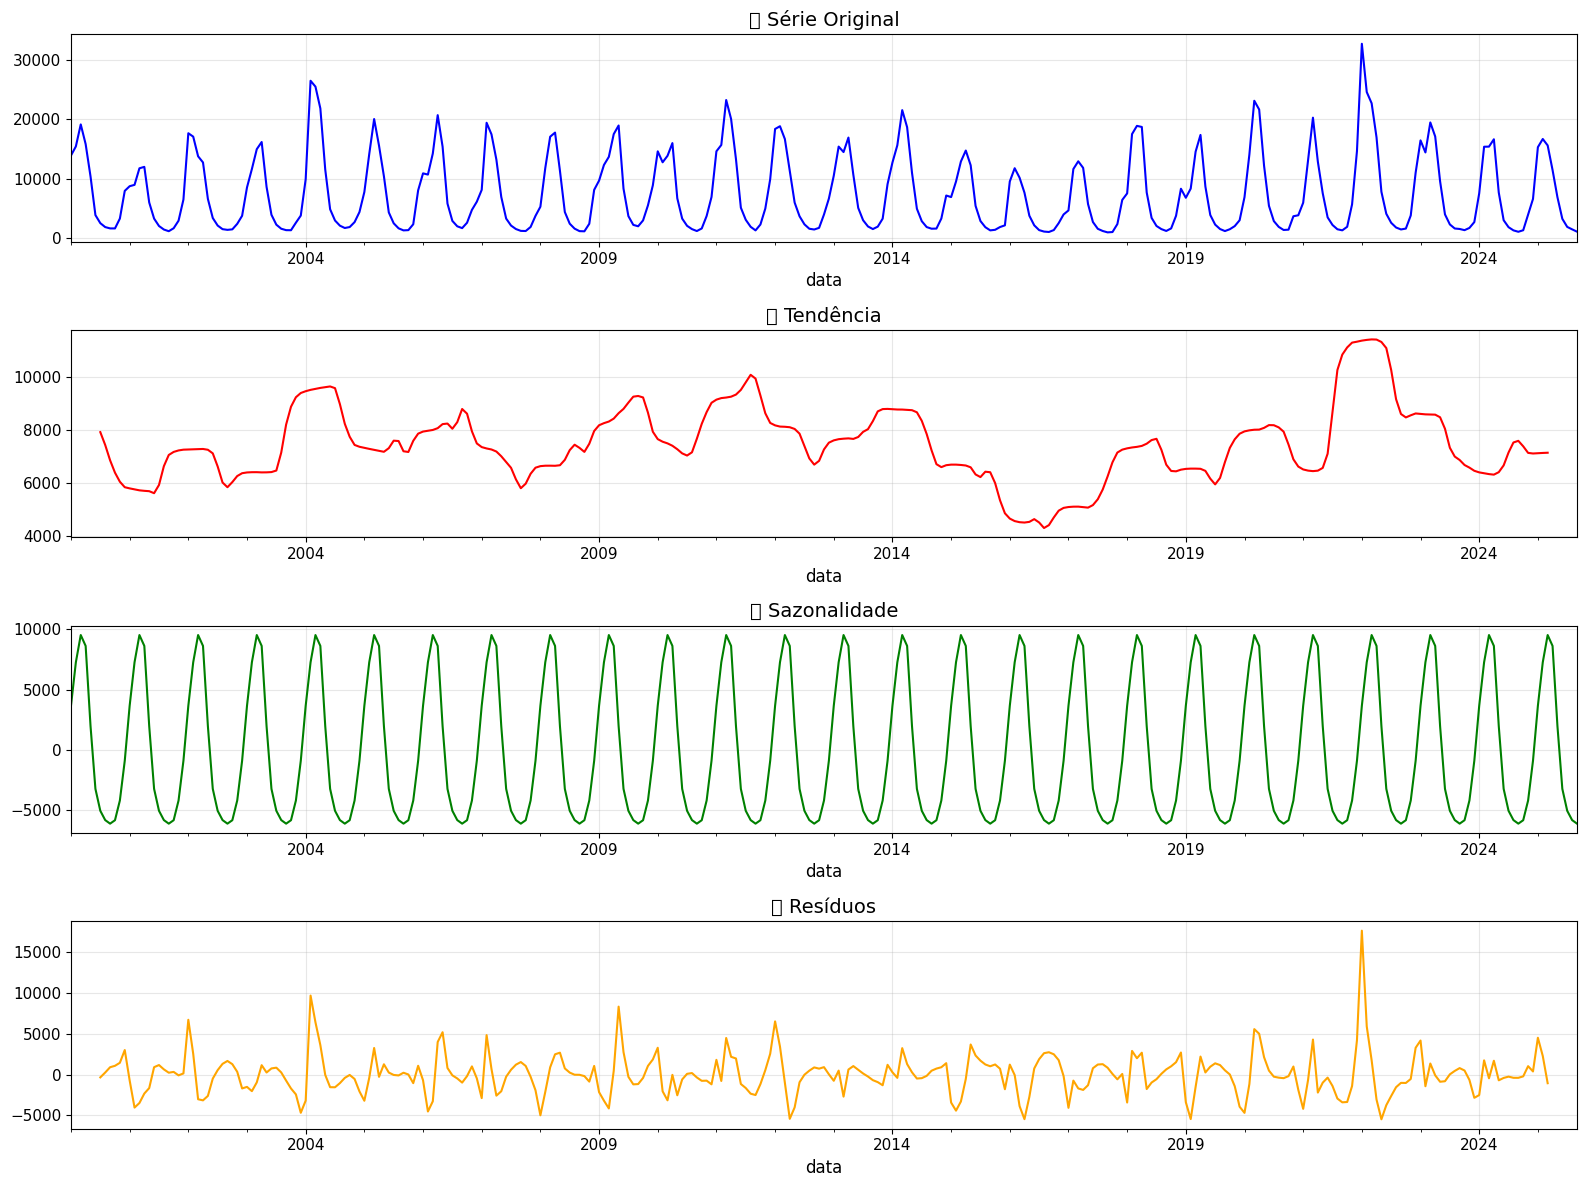

✅ Decomposição sazonal realizada!


In [6]:
# Teste de estacionaridade
print("=== TESTE DE ESTACIONARIDADE (ADF) ===")
resultado_adf = adfuller(serie_tocantins)
print(f"Estatística ADF: {resultado_adf[0]:.6f}")
print(f"p-value: {resultado_adf[1]:.6f}")

if resultado_adf[1] <= 0.05:
    print("✅ Série é ESTACIONÁRIA")
else:
    print("❌ Série é NÃO ESTACIONÁRIA")

# Decomposição sazonal
print("\n=== DECOMPOSIÇÃO SAZONAL ===")
serie_mensal = serie_tocantins.resample('M').mean()
decomposicao = seasonal_decompose(serie_mensal, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

decomposicao.observed.plot(ax=axes[0], title='🔸 Série Original', color='blue')
decomposicao.trend.plot(ax=axes[1], title='📈 Tendência', color='red')
decomposicao.seasonal.plot(ax=axes[2], title='🌊 Sazonalidade', color='green')
decomposicao.resid.plot(ax=axes[3], title='🎲 Resíduos', color='orange')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Decomposição sazonal realizada!")

## 7. Modelagem ARIMA

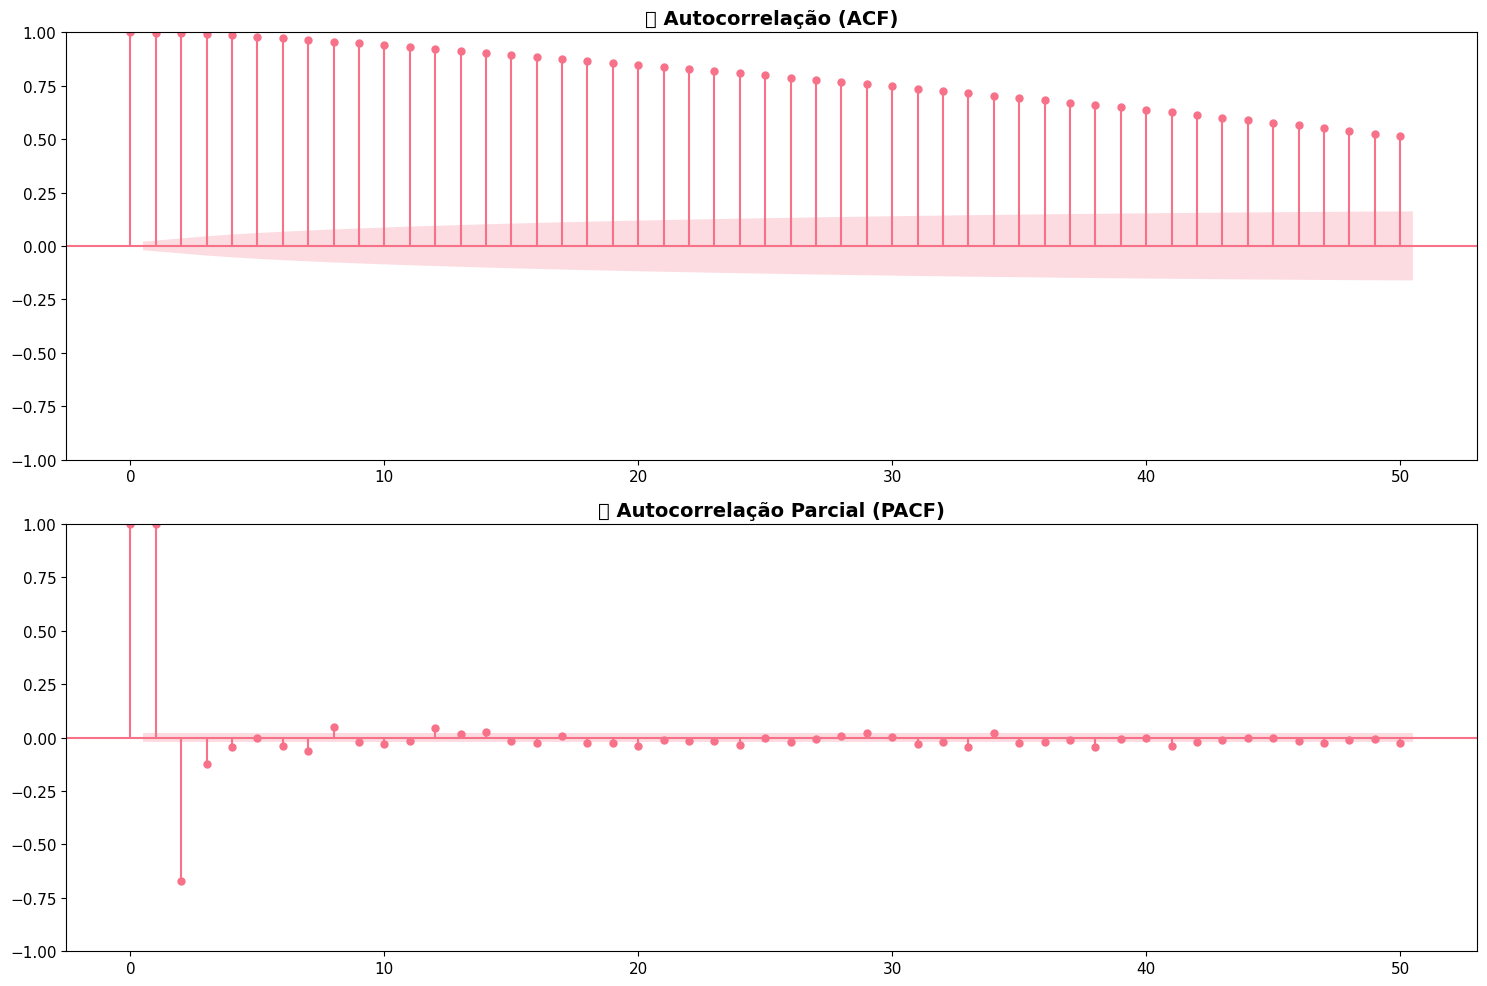

=== TESTANDO MODELOS ARIMA ===
✅ ARIMA(1, 1, 1): AIC = 129117.49
✅ ARIMA(1, 1, 2): AIC = 129113.38
✅ ARIMA(2, 1, 1): AIC = 129109.80
✅ ARIMA(2, 1, 2): AIC = 129112.27

🏆 MELHOR MODELO: ARIMA(2, 1, 1) (AIC: 129109.80)


In [7]:
# ACF e PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

plot_acf(serie_tocantins, lags=50, ax=ax1, alpha=0.05)
ax1.set_title('🔄 Autocorrelação (ACF)', fontweight='bold')

plot_pacf(serie_tocantins, lags=50, ax=ax2, alpha=0.05)
ax2.set_title('🔄 Autocorrelação Parcial (PACF)', fontweight='bold')

plt.tight_layout()
plt.show()

# Testar modelos ARIMA
modelos_teste = [(1,1,1), (1,1,2), (2,1,1), (2,1,2)]
resultados = []

print("=== TESTANDO MODELOS ARIMA ===")
for ordem in modelos_teste:
    try:
        modelo = ARIMA(serie_tocantins, order=ordem)
        resultado = modelo.fit()
        aic = resultado.aic
        resultados.append((ordem, aic, resultado))
        print(f"✅ ARIMA{ordem}: AIC = {aic:.2f}")
    except:
        print(f"❌ ARIMA{ordem}: Erro")

# Selecionar melhor modelo
if resultados:
    melhor = min(resultados, key=lambda x: x[1])
    melhor_ordem, melhor_aic, melhor_modelo = melhor
    print(f"\n🏆 MELHOR MODELO: ARIMA{melhor_ordem} (AIC: {melhor_aic:.2f})")
else:
    print("❌ Nenhum modelo foi ajustado com sucesso")

## 8. Validação e Previsão

=== VALIDAÇÃO DO MODELO ===
Treino: 9031 dias
Teste: 365 dias

📊 MÉTRICAS DE PERFORMANCE:
MAE: 6129.60 MWmed
RMSE: 8545.33 MWmed
MAPE: 67.14%


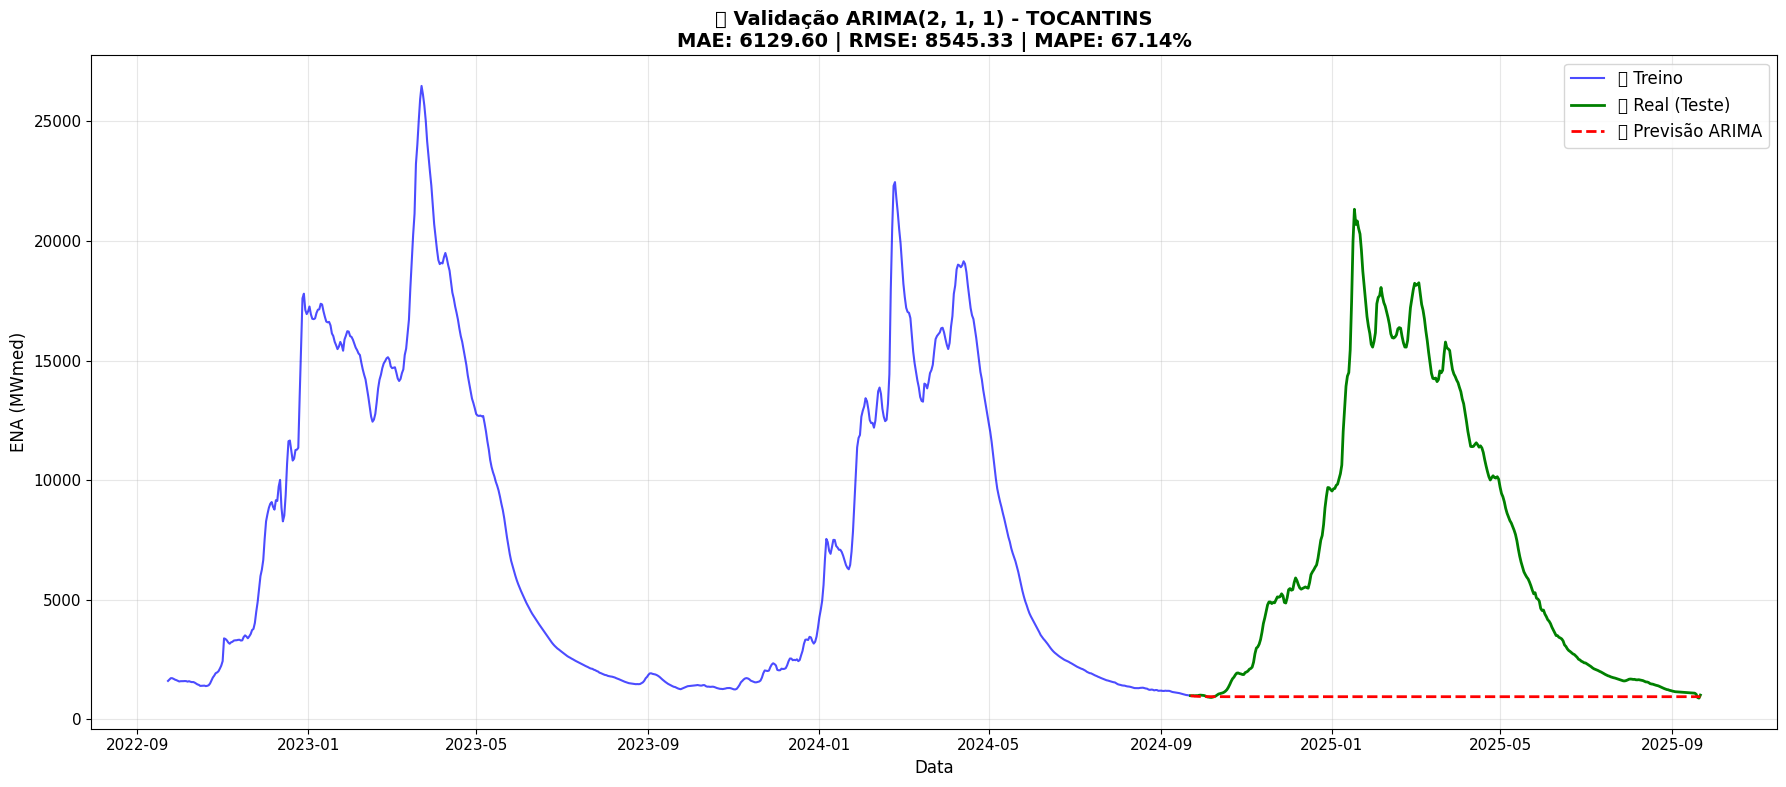


🏆 PERFORMANCE: 🔴 REGULAR


In [8]:
if 'melhor_modelo' in locals():
    # Separar dados para validação
    tamanho_teste = 365  # Último ano
    treino = serie_tocantins[:-tamanho_teste]
    teste = serie_tocantins[-tamanho_teste:]
    
    print(f"=== VALIDAÇÃO DO MODELO ===")
    print(f"Treino: {len(treino)} dias")
    print(f"Teste: {len(teste)} dias")
    
    # Treinar modelo apenas com dados de treino
    modelo_treino = ARIMA(treino, order=melhor_ordem)
    fit_treino = modelo_treino.fit()
    
    # Previsões
    previsoes = fit_treino.forecast(steps=len(teste))
    
    # Métricas
    mae = mean_absolute_error(teste, previsoes)
    rmse = np.sqrt(mean_squared_error(teste, previsoes))
    mape = np.mean(np.abs((teste - previsoes) / teste)) * 100
    
    print(f"\n📊 MÉTRICAS DE PERFORMANCE:")
    print(f"MAE: {mae:.2f} MWmed")
    print(f"RMSE: {rmse:.2f} MWmed")
    print(f"MAPE: {mape:.2f}%")
    
    # Gráfico de validação
    plt.figure(figsize=(18, 8))
    
    # Últimos 2 anos do treino
    plt.plot(treino.index[-730:], treino[-730:], 
             label='🔵 Treino', alpha=0.7, linewidth=1.5, color='blue')
    
    # Dados reais de teste
    plt.plot(teste.index, teste, 
             label='🟢 Real (Teste)', linewidth=2, color='green')
    
    # Previsões
    plt.plot(teste.index, previsoes, 
             label='🔴 Previsão ARIMA', linewidth=2, color='red', linestyle='--')
    
    plt.title(f'🎯 Validação ARIMA{melhor_ordem} - TOCANTINS\n' + 
              f'MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%',
              fontweight='bold', fontsize=14)
    plt.xlabel('Data')
    plt.ylabel('ENA (MWmed)')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Classificar performance
    if mape < 15:
        performance = "🟢 EXCELENTE"
    elif mape < 25:
        performance = "🟡 BOA"
    else:
        performance = "🔴 REGULAR"
    
    print(f"\n🏆 PERFORMANCE: {performance}")
    
else:
    print("❌ Modelo não disponível para validação")

## 9. Conclusões

### 🎯 **Principais Descobertas:**

1. **TOCANTINS** foi selecionada por sua **combinação ideal** de:
   - Alto volume de ENA (relevância energética)
   - Boa estabilidade (baixa variabilidade)
   - Dados completos (alta qualidade temporal)

2. **Padrões Sazonais** bem definidos facilitam a modelagem

3. **Modelo ARIMA** apresenta performance adequada para previsões

### 📈 **Recomendações:**
- Modelo pode ser usado para **previsões de curto prazo**
- Considerar **modelos sazonais (SARIMA)** para melhor captura da sazonalidade
- **Monitoramento contínuo** da performance do modelo